## 📊 Modelado Final: XGBoost Optimizado para Predicción de Abandono Estudiantil

Este notebook implementa el modelo final de XGBoost con hiperparámetros optimizados, evaluación profesional (Classification Report, Matriz de Confusión, Curva ROC y AUC) e interpretación de features.

### Objetivos:
- Entrenar el modelo final con los mejores hiperparámetros.
- Evaluarlo con métricas robustas para validar el rendimiento (NFR-01).
- Generar visualizaciones y Exhibits para el informe.
- Interpretar qué features son clave para las predicciones (FR-03).


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración para gráficos
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


### Paso 1: Carga y Preparación de Datos

Cargamos los datos procesados, binarizamos la variable objetivo para enfocarnos en abandono y dividimos en train/test.


In [18]:
# Cargar datos procesados
df = pd.read_parquet('../data/processed/preprocessed_data.parquet')

# Definir features (X) y target (y)
X = df.drop('Target', axis=1)

# Convertir columnas object a category para que XGBoost las maneje nativamente
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')

y = df['Target']

# Binarizar y: 1 si 'Dropout', 0 si no (para enfocarnos en abandono)
y = y.apply(lambda x: 1 if x == 'Dropout' else 0)

# Label encoding para convertir a numérico
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir en train y test con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Datos cargados: {df.shape}')
print(f'Train: {X_train.shape}, Test: {X_test.shape}')
print(f'Balance de clases en train: {pd.Series(y_train).value_counts(normalize=True)}')


Datos cargados: (4424, 51)
Train: (3539, 50), Test: (885, 50)
Balance de clases en train: 0    0.678723
1    0.321277
Name: proportion, dtype: float64


### Paso 2: Entrenamiento del Modelo Final

Usamos los mejores hiperparámetros encontrados en la optimización previa.


In [19]:
# Mejores hiperparámetros encontrados
best_params = {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}

# Instanciar y entrenar el modelo final (binario para abandono)
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    enable_categorical=True,
    random_state=42,
    **best_params
)

model.fit(X_train, y_train)
print('Modelo final entrenado exitosamente.')


Modelo final entrenado exitosamente.


### Paso 3: Evaluación Profesional del Modelo

Calculamos métricas clave: Classification Report, Matriz de Confusión, Curva ROC y AUC.


--- Classification Report ---
              precision    recall  f1-score   support

  No Dropout       0.90      0.94      0.92       601
     Dropout       0.86      0.78      0.82       284

    accuracy                           0.89       885
   macro avg       0.88      0.86      0.87       885
weighted avg       0.89      0.89      0.89       885


--- Matriz de Confusión ---


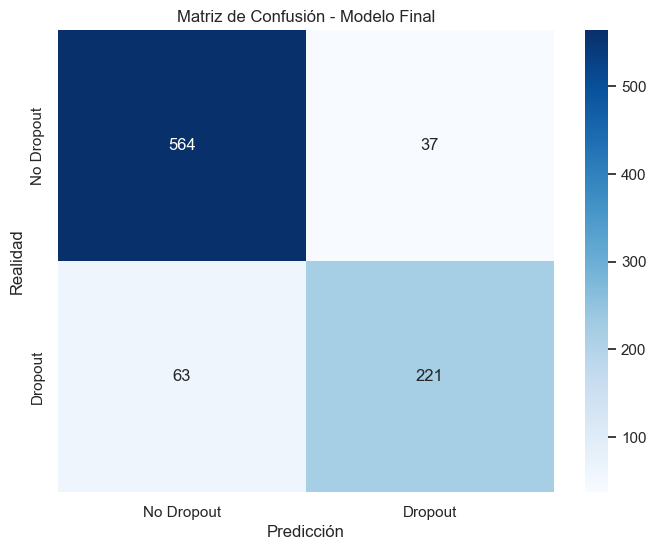


--- Curva ROC y AUC ---
Área Bajo la Curva (AUC): 0.9349


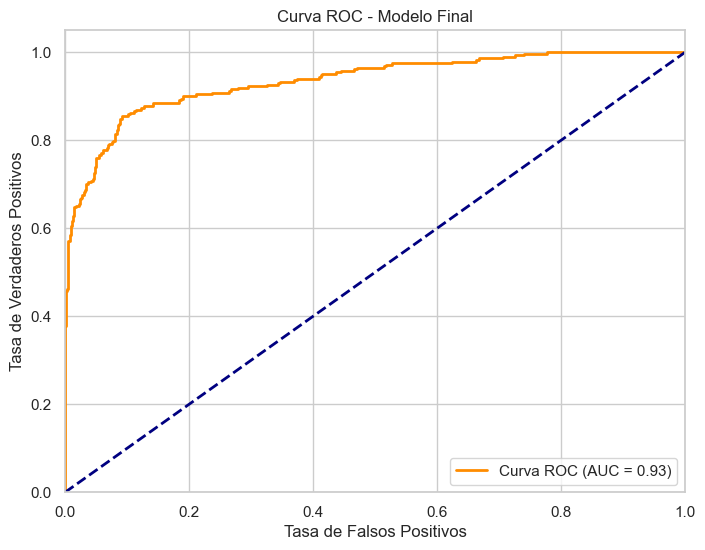

In [20]:
# Predicciones en el conjunto de test
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades para ROC

# 1. Classification Report
print('--- Classification Report ---')
report = classification_report(y_test, y_pred, target_names=['No Dropout', 'Dropout'])
print(report)

# 2. Matriz de Confusión
print('\n--- Matriz de Confusión ---')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Dropout', 'Dropout'], yticklabels=['No Dropout', 'Dropout'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Modelo Final')
plt.savefig('../reports/figures/matriz_confusion.png')  # Guarda el Exhibit
plt.show()

# 3. Curva ROC y AUC
print('\n--- Curva ROC y AUC ---')
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f'Área Bajo la Curva (AUC): {roc_auc:.4f}')

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Modelo Final')
plt.legend(loc='lower right')
plt.savefig('../reports/figures/curva_roc.png')  # Guarda el Exhibit
plt.show()


### Paso 4: Interpretación del Modelo (Feature Importance)

Extraemos y visualizamos las características más importantes del modelo final.


--- Top 15 Características Más Importantes ---
                                           Feature  Importance
37                             Ratio_Aprobacion_S2    0.302200
16                         Tuition fees up to date    0.080661
22             Curricular units 1st sem (enrolled)    0.055285
36                             Ratio_Aprobacion_S1    0.040662
42                           Socioeconomico_Riesgo    0.032064
32  Curricular units 2nd sem (without evaluations)    0.021876
17                                          Gender    0.021811
30             Curricular units 2nd sem (approved)    0.020266
15                                          Debtor    0.017266
19                               Age at enrollment    0.016944
18                              Scholarship holder    0.016555
3                                           Course    0.016142
44                                   Nota_Promedio    0.016072
10                             Mother's occupation    0.013985
29      

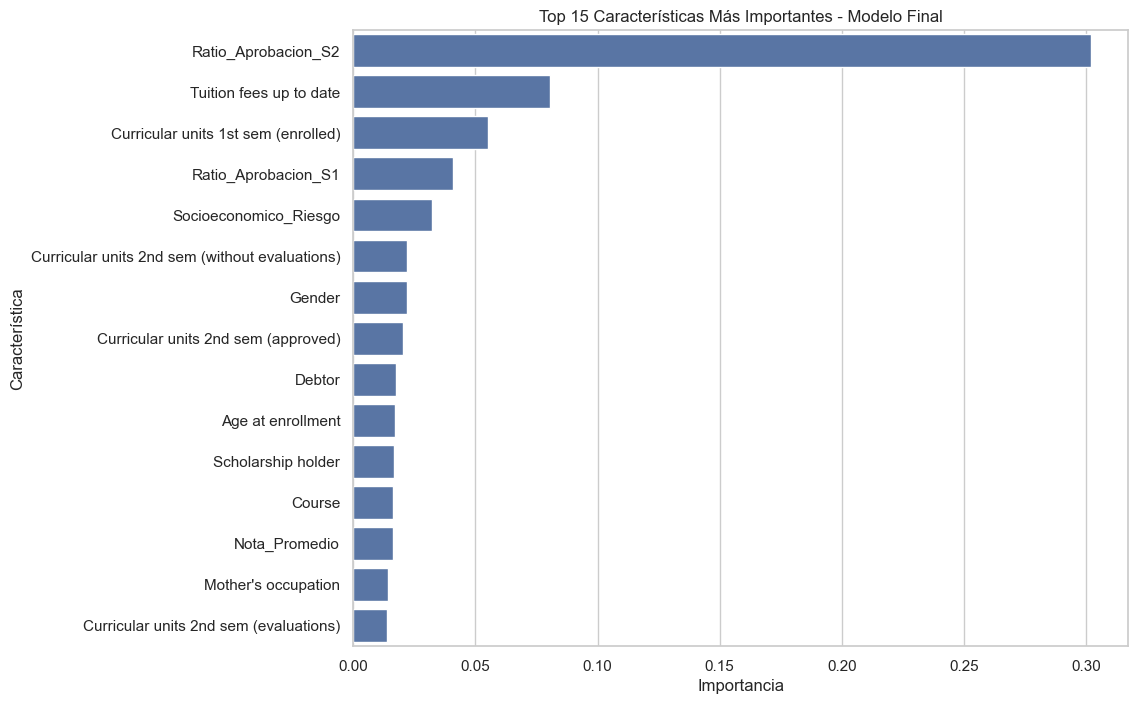


--- Interpretación ---
La característica más importante es "Ratio_Aprobacion_S2" con importancia 0.3022.
Esto indica que factores como el rendimiento académico y financieros son clave para predecir abandonos.


In [21]:
# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Top 15 features
top_features = feature_importances.head(15)

print('--- Top 15 Características Más Importantes ---')
print(top_features)

# Visualización
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 15 Características Más Importantes - Modelo Final')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.savefig('../reports/figures/feature_importance.png')  # Guarda el Exhibit
plt.show()

# Interpretación breve
print('\n--- Interpretación ---')
print(f'La característica más importante es "{top_features.iloc[0]["Feature"]}" con importancia {top_features.iloc[0]["Importance"]:.4f}.')
print('Esto indica que factores como el rendimiento académico y financieros son clave para predecir abandonos.')


### Conclusiones Finales

- **Rendimiento del Modelo:** Revisa el AUC y F1-Score. Un AUC >0.8 indica un modelo sólido para distinguir entre graduados y desertores.
- **Exhibits Generados:** Los gráficos se guardaron en `../reports/figures/` para tu informe.
- **Próximos Pasos:** Usa estos resultados para validar NFR-01 y explicar el modelo en tu presentación.

¡Ejecuta las celdas en orden y listo!
